In [1]:
%autosave 2
%matplotlib inline

Autosaving every 2 seconds


Some inbuilt magic methods for beautiful plots and autosave every 2 seconds

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt

Imported some libraries that I think I might need

In [3]:
from scipy.io import loadmat

In [4]:
df = loadmat('ex3data1.mat')

In [5]:
X, y = df['X'], df['y']
m, n = X.shape[0], X.shape[1]

Loaded the data and divided into X and y. Also stored the dimensions as m and n

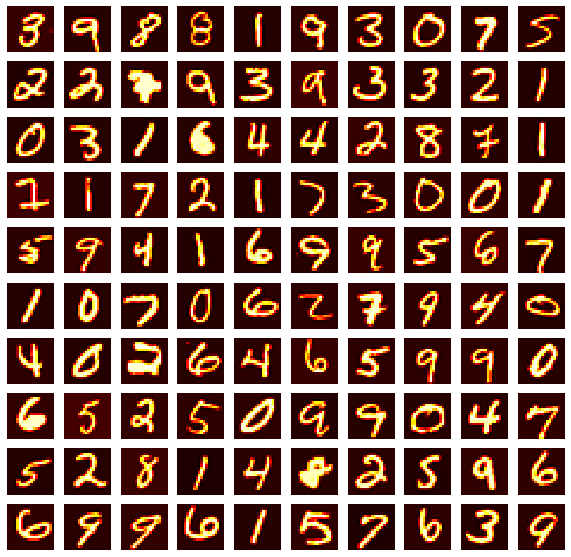

In [6]:
import matplotlib.image as mpimg
fig, axis = plt.subplots(10,10,figsize=(10,10))
for i in range(10):
    for j in range(10):
        axis[i,j].imshow(X[np.random.randint(0,5001),:].reshape(20,20,order="F"), cmap='hot') #reshape back to 20 pixel by 20 pixel
        axis[i,j].axis("off")

Visualised random 100 images from the dataset

Now, we will start building the model. As always, we will first start by building the off the shelf model using Logistic Regression class of sklearn. It natively supports multiclass classification and thus, we don't have to do much

In [7]:
from sklearn.linear_model import LogisticRegressionCV
skmodel = LogisticRegressionCV(max_iter=10000)
skmodel.fit(X, y.flatten())

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=10000, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [8]:
skpred = skmodel.predict(X)

In [9]:
from sklearn.metrics import accuracy_score
accuracy_score(y, skpred)

0.9482

In [10]:
print(skmodel.predict([X[499, :]]))

[10]


In [11]:
correct = 0
for i in range(m):
    if y[i][0] == skpred[i]:
        correct += 1
print((correct/m) * 100)

94.82000000000001


We just created a model using Logictic Regression of sklearn in just single line, and it gave an accuracy of 94.82% which is pretty high considering the work

In [12]:
y_bin = np.zeros((5000, 10))
for i in range(m):
    y_bin[i][y[i] % 10] = 1

In [13]:
y_bin

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

Creating a binary vector from single value and storing them in the matrix y_bin for our own implementation of multiclass classifier

In [14]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

In [15]:
def costFunction(theta, X, y, reg_param):
    #reg_param = 1
    m = len(y)
    predictions = sigmoid(X @ theta)
    J = sum((-y * np.log(predictions))-((1-y) * np.log(1 - predictions))) / m
    J += (reg_param / (2 * m)) * sum(theta[1:] ** 2)
    return J

In [16]:
def grad(theta, X, y, reg_param):
    #reg_param = 1
    m = len(y)
    predictions = sigmoid(X @ theta)
    error = predictions - y
    grad_term = X.transpose() @ error
    grad0 = grad_term[0] / m
    grad12n = ((grad_term[1:]) / m) + ((reg_param / m) * theta[1:])
    grad = np.append(grad0, grad12n).reshape(theta.shape)
    return grad

In [17]:
def onevsall(theta, X, y, reg_param):
    result = opt.fmin_tnc(func=costFunction, x0=theta.flatten(), fprime=grad, args=(X, y.flatten(), 1))
    return result[0].reshape(theta.shape)

10

In [18]:
def predictOneVsAll(all_theta, X):
    """
    Using all_theta, compute the probability of X(i) for each class and predict the label
    
    return a vector of prediction
    """
    m= X.shape[0]
    #X = np.hstack((np.ones((m,1)),X))
    
    predictions = X @ all_theta.T
    return np.argmax(predictions,axis=1)

In upper cells, we have defined almost all the fucntions that will be required to train our OneVsAll model from scratch. Now, we will start training the model. For experimenting, we will first train with column of ones added and then train without it

In [19]:
num_classes = y_bin.shape[1]
X_ones = np.append(np.ones((len(X), 1)), X, axis=1)

(5000, 401)

In [20]:
all_theta = np.zeros((X_ones.shape[1], 1))
for i in range(num_classes):
    ini_theta = np.zeros((X_ones.shape[1], 1))
    result = onevsall(ini_theta, X_ones, y_bin[:, i], 1)
    all_theta = np.append(all_theta, result, axis=1)
    print(i)

0
1
2
3
4
5
6
7
8
9


In [21]:
fin_theta = all_theta[:, 1:].transpose()

In [22]:
pred = predictOneVsAll(fin_theta, X_ones)
print("Training Set Accuracy:",sum(pred[:,np.newaxis]==y)[0]/5000*100,"%")

Training Set Accuracy: 84.54 %


In [23]:
all_theta2 = np.zeros((X.shape[1], 1))
for i in range(num_classes):
    ini_theta = np.zeros((X.shape[1], 1))
    result = onevsall(ini_theta, X, y_bin[:, i], 1)
    all_theta2 = np.append(all_theta2, result, axis=1)
    print(i)

0
1
2
3
4
5
6
7
8
9


In [24]:
fin_theta2 = all_theta2[:, 1:].transpose()

In [26]:
pred2 = predictOneVsAll(fin_theta2, X)
print("Training Set Accuracy:",sum(pred2[:,np.newaxis]==y)[0]/5000*100,"%")

Training Set Accuracy: 84.17999999999999 %


As we can see, with columns of one, the accuracy is slightly higher than that of without that column